# Import Lib

In [1]:
# Import the libraries
import tensorflow as tf
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize
figsize(15, 7) 

# Cuda Error

In [2]:
def solve_cudnn_error():
    #import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized# Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


# Utils

In [17]:
def read_data(path):
    df = pd.read_csv(path, sep=',', parse_dates={'dt':['Datetime']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'], index_col='dt')

    df = df.reindex(index=df.index[::-1])

    # filling nan with mean in any columns
    for j in range(df.shape[1]):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
    #df.iloc[:,4:] = df.iloc[:,4:]*100
    # another sanity check to make sure that there are not more any nan
    print(df.isnull().sum())
    print(df.head())
    return df
#draw_trend
def draw_trend(df,groups,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        plt.title(df.columns[group], y=0.80, loc='right')
        #plt.xticks(range(0,4020,20))
        i += 1
    plt.show()
    print('\n')

def draw_trend_resample(df,groups,resample_freq,bound=200):
    #figsize(15,10) 
    i=1
    Values = df.resample(resample_freq).mean().values
    cols = groups
    for group in groups:
        plt.subplot(len(cols), 1, i)
        plt.plot(Values[:bound, group],linewidth=3)
        #plt.xticks(range(0,bound+10,10))
        plt.title(df.columns[group]+' resample-{}'.format(resample_freq), y=0.80, loc='right')
        i += 1
    plt.tight_layout()
    plt.show()
    
    print('\n')
#draw_corr
def show_corr(df,group):
    plt.matshow(df.iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_original', size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    
def show_corr_resample(df,group,resample_freq):
    plt.matshow(df.resample(resample_freq).mean().iloc[:,group].corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
    plt.title('Spearman_resample-{}'.format(resample_freq), size=15)
    plt.xticks(range(len(group)),labels=map(str,group))
    plt.yticks(range(len(group)),labels=map(str,group))
    plt.colorbar()
    plt.show()
    

In [18]:
def gen_dataset(data,y_column_list,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, :])
        y_train.append(data[i:i+y_window_size, y_column_list ])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    
    
    X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))
    print(y_train.shape)
    if y_window_size == 1:
        y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[2]))
    else:
        y_train = np.reshape(y_train,(y_train.shape[0],y_window_size,y_train.shape[2]))
    print("Gen data info:")
    print("X_data_shape:{}".format(X_train.shape))
    print("y_data_shape:{}".format(y_train.shape))
    print("\n")
          
    
    return X_train,y_train

def data_scaling(data,X_win_size,y_win_size,mode='robust'):
    
    assert mode == 'robust' or mode == 'minmax','Wrong mode name'
    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler,RobustScaler
    #data:df type
    print(type(data.loc['2021-02']))
    training_set=data.loc['2021-02'].values
    testing_set=data.loc['2021-03'].values
    print("Mode:{}\n".format(mode))
    if mode =='robust':
        
         #RobustScaler
        
        sc_train = RobustScaler()
        X_train_scaled = sc_train.fit_transform(training_set)    

        sc_test = RobustScaler()
        X_test_scaled = sc_test.fit_transform(testing_set)
    
    elif mode == 'minmax':
        
        #MinMaxScaler
        
        #sc_train = MinMaxScaler(feature_range=(0,1))
        sc_train = MinMaxScaler(feature_range=(0,1))
        X_train_scaled = sc_train.fit_transform(training_set)    

        sc_test = MinMaxScaler(feature_range=(0,1))
        X_test_scaled = sc_test.fit_transform(testing_set)
        
        
    

    y_column=[4,5,6,7]
    
    #gen dataset
    train_X,train_y = gen_dataset(X_train_scaled,y_column,X_win_size,y_win_size)
    test_X,test_y = gen_dataset(X_test_scaled,y_column,X_win_size,y_win_size)
    org_test_x,org_test_y= gen_dataset(testing_set,y_column,X_win_size,y_win_size)
    
    print("Data shape info:")
    print("origin_test_data:{}".format(testing_set.shape))
    print("X_train:{}".format(train_X.shape))
    print("y_train:{}".format(train_y.shape))
    print("X_test:{}".format(test_X.shape))
    print("y_test:{}".format(test_y.shape))
    print("O_X_test:{}".format(org_test_x.shape))
    print("O_y_test:{}".format(org_test_y.shape))
    
    #return original test data, 
    
    return training_set,testing_set,train_X,train_y,test_X,test_y,sc_test,org_test_y

# Training Proccess

In [19]:
df = read_data(path='./dataset/Zabbix_monitor_SB/Concate_OPLS_PW.csv')

    

1V_Memory_usage    0
2V_Memory_usage    0
3V_Memory_usage    0
4V_Memory_usage    0
1V_CPU_usage       0
2V_CPU_usage       0
3V_CPU_usage       0
4V_CPU_usage       0
dtype: int64
                     1V_Memory_usage  2V_Memory_usage  3V_Memory_usage  \
dt                                                                       
2021-02-08 17:09:00           7.5909           5.4956         8.897095   
2021-02-08 17:12:00           7.5795           5.4926         8.897095   
2021-02-08 17:15:00           7.5594           5.4660         8.897095   
2021-02-08 17:18:00           7.5794           5.4839         6.039600   
2021-02-08 17:21:00           7.5564           5.5077         6.026300   

                     4V_Memory_usage  1V_CPU_usage  2V_CPU_usage  \
dt                                                                 
2021-02-08 17:09:00        12.434395        0.4230        0.2829   
2021-02-08 17:12:00        12.434395        0.3547        0.3876   
2021-02-08 17:15:00        1

In [20]:
#@title 預設標題文字
X_WIN = 20
Y_WIN = 1
SCALE_MODE = 'robust'


origin_train_data,origin_test_data,X_train,y_train,X_test,y_test,sc_test,orgin_test_y = data_scaling(df,X_WIN,Y_WIN,mode=SCALE_MODE)

<class 'pandas.core.frame.DataFrame'>
Mode:robust

(9714, 1, 4)
Gen data info:
X_data_shape:(9714, 20, 8)
y_data_shape:(9714, 4)


(4642, 1, 4)
Gen data info:
X_data_shape:(4642, 20, 8)
y_data_shape:(4642, 4)


(4642, 1, 4)
Gen data info:
X_data_shape:(4642, 20, 8)
y_data_shape:(4642, 4)


Data shape info:
origin_test_data:(4663, 8)
X_train:(9714, 20, 8)
y_train:(9714, 4)
X_test:(4642, 20, 8)
y_test:(4642, 4)
O_X_test:(4642, 20, 8)
O_y_test:(4642, 4)


In [21]:
def model_chk(path):
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)
    
    print("checkpoint save in {}".format(path))
    
    return checkpoint

# Run if new training proccess

In [22]:
test_model = TCN(input_shape=(X_train.shape[1],X_train.shape[2]),
        nb_filters=64,
        kernel_size=3,
        nb_stacks=2,
        dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.0,
        return_sequences=False,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=False,
        use_layer_norm=False,
        use_weight_norm=False)

Model(test_model,)

SyntaxError: invalid syntax (<ipython-input-22-3233b9770aef>, line 15)

In [25]:
import tensorflow as tf
import shutil,os
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam


#For Training
def clean_folder(path):
    
    
    shutil.rmtree(path) 
    os.mkdir(path) 

def tensorboard_setting(name):

    logdir = os.path.join("./logs", name+"-"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    return tensorboard_callback
    
def setup_tfboard(clean=False,log_name_type="exp"):
    #import tensorflow as tf
    if clean == False:
        print("Continue using current logs")
        callback = tensorboard_setting(log_name_type)
    else:
        print("Clean current logs") 
        clean_folder("logs")
        callback = tensorboard_setting(log_name_type)
    
    return callback

#For Testing
def prediction(sc,test,origin_data):
    
    #pred_list = []
    pred = model.predict(test)
    print(origin_data.shape)
    print(origin_data.shape)
    plt.plot(origin_data)
    plt.show()
    res = sc.inverse_transform(np.concatenate([origin_data,pred],axis=1))
    #pred_list.append(res[:,4:])
    return res

def cal_score(y_real,y_hat):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))

    return round(MAEScore,3),round(RMSEScore,3)

def draw_compare(real_data,pred_data):

    print(cal_score(real_data,pred_data))
    
    plt.plot(real_data,color = 'red',marker='.', label = 'Real MEM Used',linewidth=3)
    plt.plot(pred_data,color = 'blue', label = 'Predicted MEM Used',linewidth=3)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.legend(fontsize='xx-large')
    plt.xlabel('Sequence',fontsize=20)
    plt.ylabel('24H Detection Trend Values',fontsize=20)
    plt.title('predicted values and actual values on test data',fontsize=20)
    plt.show()

In [13]:
from tcn import TCN,tcn_full_summary
import datetime
tensorboard_callback = setup_tfboard(clean=True,log_name_type='filter')
best_model = model_chk("Model/TCN/best.h5")

print(" ")

model = Sequential([
    TCN(input_shape=(X_train.shape[1],X_train.shape[2]),
        nb_filters=64,
        kernel_size=3,
        nb_stacks=2,
        dilations=(1, 2, 4, 8, 16, 32),
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.0,
        return_sequences=False,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=False,
        use_layer_norm=False,
        use_weight_norm=False
        ),
    Dense(y_train.shape[1], activation='linear')
])

model.summary()
#tcn_full_summary(model, expand_residual_blocks=False)
model.compile('adam', 'mae')

print('\nTrain...')



model.fit(X_train,y_train, epochs=100, verbose=2,callbacks=[tensorboard_callback,best_model],shuffle=False)



Clean current logs
checkpoint save in Model/TCN/best.h5
 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 64)                286272    
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 286,532
Trainable params: 286,532
Non-trainable params: 0
_________________________________________________________________

Train...
Epoch 1/100
304/304 - 13s - loss: 2.4466
Epoch 2/100
304/304 - 6s - loss: 1.2780
Epoch 3/100
304/304 - 6s - loss: 1.1332
Epoch 4/100
304/304 - 6s - loss: 1.0295
Epoch 5/100
304/304 - 6s - loss: 0.9904
Epoch 6/100
304/304 - 6s - loss: 0.9709
Epoch 7/100
304/304 - 6s - loss: 0.9485
Epoch 8/100
304/304 - 6s - loss: 0.9389
Epoch 9/100
304/304 - 6s - loss: 0.9003
Epoch 10/100
304/304 - 6s - loss: 0.8891
Epoch 11/100
304/304 - 6s - loss: 0.9006
E

(4642, 4)
(4642, 4)


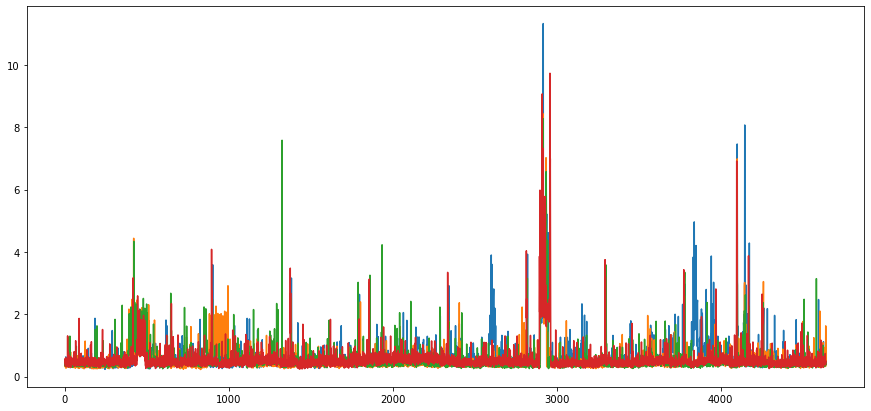

(0.251, 0.504)


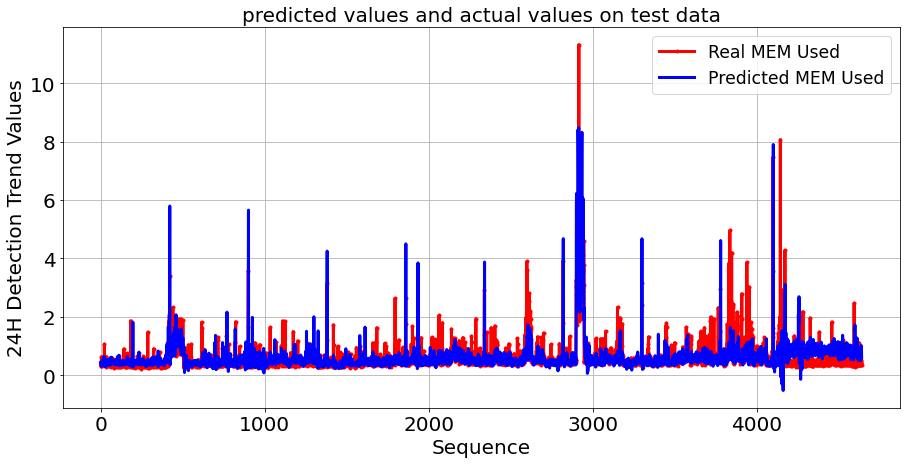

In [32]:
#from my_utils import *
#print(orgin_test_y[:,:,:].shape)
pred = prediction(sc=sc_test,test=X_test,origin_data=orgin_test_y)
draw_compare(origin_test_data[21:,4],pred[:,4])

In [46]:
%load_ext tensorboard

In [54]:
%tensorboard --logdir logs --port 6006

Reusing TensorBoard on port 6006 (pid 15884), started 0:16:33 ago. (Use '!kill 15884' to kill it.)

In [75]:
def cal_score(y_real,y_hat):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    import math

    MAEScore = mean_absolute_error(y_real,y_hat)
    RMSEScore = math.sqrt(mean_squared_error(y_real,y_hat))

    return round(MAEScore,3),round(RMSEScore,3)

In [76]:
cal_score(origin_test_data[61:,4],pred[:,0])

(0.269, 0.573)